This is this eighth in a series of notebooks designed to show you how to analyze social media data. For demonstration purposes we are looking at tweets sent by CSR-related Twitter accounts -- accounts related to ethics, equality, the environment, etc. -- of Fortune 200 firms in 2013. I assume you have already downloaded the data and have completed the steps taken in previous chapters:

- <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%201%20-%20Import%20Data%2C%20Select%20Cases%20and%20Variables%2C%20Save%20DataFrame.ipynb" target="_blank">Chapter 1 - Import Data, Select Cases and Variables, Save DataFrame</a>
- <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%202%20-%20Aggregating%20and%20Analyzing%20Data%20by%20Twitter%20Account.ipynb" target="_blank">Chapter 2 - Aggregating and Analyzing Data by Twitter Account</a>
- <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%203%20-%20Analyzing%20Twitter%20Data%20by%20Time%20Period.ipynb" target="_blank">Chapter 3 - Analyzing Twitter Data by Time Period</a>
- <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%204%20-%20Analyzing%20Hashtags.ipynb" target="_blank">Chapter 4 - Analyzing Hashtags</a>
- <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%205%20-%20Generating%20New%20Variables.ipynb" target="_blank">Chapter 5 - Generating New Variables</a>
- <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%206%20-%20Producing%20a%20Summary%20Statistics%20Table%20for%20Publication.ipynb" target="blank">Chapter 6 - Producing a Summary Statistics Table for Publication</a>
- <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%207%20-%20Analyzing%20Audience%20Reaction%20on%20Twitter.ipynb" target="blank">Chapter 7 - Analyzing Audience Reaction on Twitter</a>

In this notebook I will show you how to run, interpret, and output a logistic regression. Whenever you have a <i>binary</i> dependent variable such as `RTs_binary`, you'll want to run logistic or probit model for your regressions. 
<br>

# Chapter 8: Logistic Regression

In our dataframe we have four potential dependent variables: `retweet_count`, `favorite_count`, `RTs_binary`, and `favorites_binary`. The first two are ratio-level <i>count</i> variables, while the last two are binary `(0,1)` variables. 

Whenever you have a <i>count</i> dependent variable, you'll want to run a Poisson or Negative Binomial model for your regressions. With social media-based count data, such as the number of followers, the number of tweets, or the number of retweets, Poisson is rarely a good fit. Thus we typically run the negative binomial model. 

In this tutorial we will focus on `RTs_binary`. This variable numerically differentiates retweeted tweets from ignored tweets. As we saw in <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%207%20-%20Analyzing%20Audience%20Reaction%20on%20Twitter.ipynb" target="blank">Chapter 7</a>, `45%` of all tweets in our database never receive a retweet; our binary variable thus taps a meaningful distinction between the retweeted and non-retweeted messages. 

In turn, with binary dependent variables such as `RTs_binary`, the logit or probit model is commonly used. For ease of presentation, in this tutorial I will focus on logistic regression using the example of `RTs_binary`. I'll show you how to run logistic regression. Just as importantly, I will show you how to run multiple models and present the output in an almost publication-ready format.

### Import packages and set viewing options

As per normal, we will first import several necessary Python packages and set some options for viewing the data. As with prior chapters, we will be using the <a href="http://pandas.pydata.org/">Python Data Analysis Library,</a> or <i>PANDAS</i>, extensively for our data manipulations.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series

In [2]:
#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)

I'm using version 0.16.2 of PANDAS

In [3]:
pd.__version__

'0.16.2'

<br>In this tutorial we will be using the increasingly powerful Python statistics package `StatsModels`. With this package, Python is now able to compete with other statistical programs such as SPSS, Stata, SAS, and `R`. While it's not yet as powerful as those other tools, it is relatively new and becoming more powerful every day. You will find you can do almost everything you need to do right in Python.

In [4]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf   #FOR USING 'R'-STYLE FORMULAS FOR REGRESSIONS
print statsmodels.__version__

0.6.1


<br>I like suppressing scientific notation in my numbers. So, if you'd rather see "0.48" than "4.800000e-01", then run the following line:

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#### Import graphing packages

In [6]:
import matplotlib
import matplotlib.pyplot as plt
print matplotlib.__version__

1.4.3


In [7]:
#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*

In [8]:
%matplotlib inline 

In [9]:
import seaborn as sns
print sns.__version__

0.6.0


In [10]:
plt.rcParams['figure.figsize'] = (15, 5)

<br>
### Read in Data

In <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%204%20-%20Analyzing%20Hashtags.ipynb" target="_blank">Chapter 4</a> we created a version of the dataframe that omitted all tweets that were retweets, allowing us to focus only on original messages sent by the 41 Twitter accounts. In <a href="http://nbviewer.ipython.org/github/gdsaxton/PANDAS/blob/master/Chapter%205%20-%20Generating%20New%20Variables.ipynb" target="_blank">Chapter 5</a> we then added 6 new variables to this dataset. Let's now open this saved file. As we can see in the operations below this dataframe contains 60 variables for 26,257 tweets.

In [11]:
df = pd.read_pickle('Original 2013 CSR Tweets with 3 binary variables.pkl')
print "# of variables in dataframe:", len(df.columns)
print  "# of tweets in dataframe:", len(df)
df.head(2)

# of variables in dataframe: 60
# of tweets in dataframe: 26257


,rowid,query,tweet_id_str,inserted_date,language,coordinates,retweeted_status,created_at,month,year,content,from_user_screen_name,from_user_id,from_user_followers_count,from_user_friends_count,from_user_listed_count,from_user_favourites_count,from_user_statuses_count,from_user_description,from_user_location,from_user_created_at,retweet_count,favorite_count,entities_urls,entities_urls_count,entities_hashtags,entities_hashtags_count,entities_mentions,entities_mentions_count,in_reply_to_screen_name,in_reply_to_status_id,source,entities_expanded_urls,entities_media_count,media_expanded_url,media_url,media_type,video_link,photo_link,twitpic,num_characters,num_words,retweeted_user,retweeted_user_description,retweeted_user_screen_name,retweeted_user_followers_count,retweeted_user_listed_count,retweeted_user_statuses_count,retweeted_user_location,retweeted_tweet_created_at,Fortune_2012_rank,Company,CSR_sustainability,specific_project_initiative_area,English,RTs_binary,favorites_binary,hashtags_binary,mentions_binary,URLs_binary
0,67340,humanavitality,306897327585652736,2014-03-09 13:46:50.222857,en,NaN,NaN,2013-02-27 22:43:19.000000,2,2013,@louloushive (Tweet 2) We encourage other empl...,humanavitality,274041023,2859,440,38,25,1766,This is the official Twitter account for Human...,NaN,Tue Mar 29 16:23:02 +0000 2011,0,0,NaN,0,NaN,0,louloushive,1,louloushive,306218267737989120.00,web,NaN,nan,NaN,NaN,NaN,0,0,0,121,19,nan,NaN,NaN,nan,nan,nan,NaN,NaN,79,Humana,0,1,1.00,0,0,0,1,0
1,39454,FundacionPfizer,308616393706844160,2014-03-09 13:38:20.679967,es,NaN,NaN,2013-03-04 16:34:17.000000,3,2013,¿Sabes por qué la #vacuna contra la #neumonía ...,FundacionPfizer,188384056,2464,597,50,11,2400,Noticias sobre Responsabilidad Social y Fundac...,México,Wed Sep 08 16:14:11 +0000 2010,1,0,NaN,0,"vacuna, neumonía",2,NaN,0,NaN,nan,web,NaN,nan,NaN,NaN,NaN,0,0,0,138,20,nan,NaN,NaN,nan,nan,nan,NaN,NaN,40,Pfizer,0,1,0.00,1,0,1,0,0


In [12]:
print df.columns.tolist()

['rowid', 'query', 'tweet_id_str', 'inserted_date', 'language', 'coordinates', 'retweeted_status', 'created_at', 'month', 'year', 'content', 'from_user_screen_name', 'from_user_id', 'from_user_followers_count', 'from_user_friends_count', 'from_user_listed_count', 'from_user_favourites_count', 'from_user_statuses_count', 'from_user_description', 'from_user_location', 'from_user_created_at', 'retweet_count', 'favorite_count', 'entities_urls', 'entities_urls_count', 'entities_hashtags', 'entities_hashtags_count', 'entities_mentions', 'entities_mentions_count', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'source', 'entities_expanded_urls', 'entities_media_count', 'media_expanded_url', 'media_url', 'media_type', 'video_link', 'photo_link', 'twitpic', 'num_characters', 'num_words', 'retweeted_user', 'retweeted_user_description', 'retweeted_user_screen_name', 'retweeted_user_followers_count', 'retweeted_user_listed_count', 'retweeted_user_statuses_count', 'retweeted_user_location', 'r

<br>
### Create sub-set of data

For ease of presentation, let's create a more limited version of our data -- we'll keep just 8 columns.

In [13]:
df = df[['RTs_binary', 'English', 'hashtags_binary', 'mentions_binary', 'URLs_binary', 'from_user_followers_count', 'from_user_statuses_count', 'num_characters',  ]]
print "# of variables in dataframe:", len(df.columns)
print  "# of tweets in dataframe:", len(df)
df.head(2)

# of variables in dataframe: 8
# of tweets in dataframe: 26257


,RTs_binary,English,hashtags_binary,mentions_binary,URLs_binary,from_user_followers_count,from_user_statuses_count,num_characters
0,0,1.00,0,1,0,2859,1766,121
1,1,0.00,1,0,0,2464,2400,138


<br>
### Describe the Data

As shown below, we have our dependent variable `RTs_binary` and 7 potential independent (explanatory) variables, four of which are binary and three of which are ratio-level. 

In [14]:
np.round(df.describe(), 2).T[['count','mean', 'std', 'min', 'max']]

,count,mean,std,min,max
RTs_binary,26257.00,0.55,0.50,0.00,1.00
English,26257.00,0.97,0.17,0.00,1.00
hashtags_binary,26257.00,0.63,0.48,0.00,1.00
mentions_binary,26257.00,0.61,0.49,0.00,1.00
URLs_binary,26257.00,0.62,0.49,0.00,1.00
from_user_followers_count,26257.00,48397.00,103199.48,58.00,424892.00
from_user_statuses_count,26257.00,5190.04,4004.43,9.00,16594.00
num_characters,26257.00,111.11,29.89,9.00,159.00


<br>
## Logit Regressions

As an aside, StatsModels has a wiki page, https://github.com/statsmodels/statsmodels/wiki/Examples with a collection "official" and user-contributed examples, tutorials and recipes.  

StatsModels has two main ways of writing regression equations. Here I'll be using the `"R-style"` of writing regression formulas. For a more detailed explanation see http://statsmodels.sourceforge.net/devel/example_formulas.html 

Let's run a simple model with two explanatory variables: `hashtags_binary` and `from_users_followers_count`.

In [15]:
mod_logit = smf.logit(formula='RTs_binary ~ hashtags_binary + from_user_followers_count', data=df).fit()

Optimization terminated successfully.
         Current function value: 0.654336
         Iterations 5


<br>To get the summary of the above model -- including the degress of freedom, coefficients, etc. -- we use the `summary` command.

In [16]:
print mod_logit.summary()
print "Chi-squared value:", mod_logit.llr #TO GET THE CHI-SQUARED VALUE

                           Logit Regression Results                           
Dep. Variable:             RTs_binary   No. Observations:                26257
Model:                          Logit   Df Residuals:                    26254
Method:                           MLE   Df Model:                            2
Date:                Sun, 02 Aug 2015   Pseudo R-squ.:                 0.05021
Time:                        16:09:36   Log-Likelihood:                -17181.
converged:                       True   LL-Null:                       -18089.
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                    -0.5396      0.022    -24.708      0.000        -0.582    -0.497
hashtags_binary               0.9466      0.026     35.767      0.000         0.895   

<br>With a logit regression we are particularly interested in several pieces of information:

<b>Model Summary:</b>

First, we are interested in the performance of the entire regression model. 

- <b><i>`Log-Likelihood:`</i></b> The log-likelihood value of the final model.  The value `-17181` has no meaning in and of itself; rather, this number can be used to help compare nested models.
- <b><i>`No. Observations:`</i></b> The number of observations used in the regression.
- <b><i>`Chi-squared:`</i></b> "This is the likelihood ratio (LR) chi-square test."It is a measure of model fit.
- <b><i>`LLR p-value:`</i></b> The p-value for the chi-square test
   - The chi-squared probability of getting a log-likelihood ratio statistic greater than llr.  llr has a chi-squared distribution with degrees of freedom `df_model`.
   - "This is the probability of obtaining the chi-square statistic given that the null hypothesis is true.  In other words, this is the probability of obtaining this chi-square statistic (`1816.5`) if there is in fact no effect of the independent variables, taken together, on the dependent variable.  This is, of course, the p-value, which is compared to a critical value, perhaps .05 or .01 to determine if the overall model is statistically significant.  In this case, the model is statistically significant because the p-value is less than .000" (www.ats.ucla.edu)
- <b><i>`Pseudo R-squ:`</i></b> The 'pseudo' R-squared
   - "This is the pseudo R-squared.  Logistic regression does not have an equivalent to the R-squared that is found in OLS regression; however, many people have tried to come up with one.  There are a wide variety of pseudo-R-square statistics.  Because this statistic does not mean what R-square means in OLS regression (the proportion of variance explained by the predictors), we suggest interpreting this statistic with great caution." (www.ats.ucla.edu)


Below the model summary we have the parameter estimates. These are used for making determinations of the relationships for each of the individual variables.

<b>Parameter Estimates:</b>

- <b><i>`coef`</i></b> - Parameter coefficients
   - "These are the values for the logistic regression equation for predicting the dependent variable from the independent variable.  They are in log-odds units.  Similar to OLS regression, the prediction equation is" (www.ats.ucla.edu)

      - log(p/1-p) = b0 + b1$*$hashtags_binary + b2$*$from_user_followers_count
    
   - where p is the probability of being retweeted.  Expressed in terms of the variables used in this example, the logistic regression equation is

      - log(p/1-p) = -0.5396 + 0.9466$*$hashtags_binary + 3.033e-06$*$from_user_followers_count

  - "These estimates tell you about the relationship between the independent variables and the dependent variable, where the dependent variable is on the logit scale.  These estimates tell the amount of increase in the predicted log odds of `RTs_binary` = 1 that would be predicted by a 1 unit increase in the predictor, holding all other predictors constant.  Note: For the independent variables which are not significant, the coefficients are not significantly different from 0, which should be taken into account when interpreting the coefficients.  (See the columns with the z-values and p-values regarding testing whether the coefficients are statistically significant).  Because these coefficients are in log-odds units, they are often difficult to interpret, so they are often converted into odds ratios." (www.ats.ucla.edu) I will show you how to do this later

    - `hashtags_binary` - The coefficient (or parameter estimate) for the variable hashtags_binary is 0.9466.  This means that for a one-unit increase in female (in other words, going from no hashtags to hashtags), we expect a 0.9466 increase in the log-odds of the dependent variable `RTs_binary`, holding all other independent variables constant.
    
    - `from_user_followers_count` - For every one-unit increase in `from_user_followers_count` (so, for every additional follower), we expect a 3.033e-06 increase in the log-odds of `RTs_binary`, holding all other independent variables constant.
    
    - constant - This is the expected value of the log-odds of `RTs_binary` when all of the predictor variables equal zero.  In most cases, this is not interesting.  Also, oftentimes zero is not a realistic value for a variable to take.


- <b><i>`std err`</i></b> - "These are the standard errors associated with the coefficients.  The standard error is used for testing whether the parameter is significantly different from 0; by dividing the parameter estimate by the standard error you obtain a z-value (see the column with z-values and p-values).  The standard errors can also be used to form a confidence interval for the parameter, as shown in the last two columns of this table." (www.ats.ucla.edu)


- <b><i>`z and P>|z|`</i></b> - z-value and 2-tailed p-value

  - "These columns provide the z-value and 2-tailed p-value used in testing the null hypothesis that the coefficient (parameter) is 0.   If you use a 2-tailed test, then you would compare each p-value to your preselected value of alpha.  Coefficients having p-values less than alpha are statistically significant.  For example, if you chose alpha to be 0.05, coefficients having a p-value of 0.05 or less would be statistically significant (i.e., you can reject the null hypothesis and say that the coefficient is significantly different from 0).   If you use a 1-tailed test (i.e., you predict that the parameter will go in a particular direction), then you can divide the p-value by 2 before comparing it to your preselected alpha level." (www.ats.ucla.edu) 
      - With a 2-tailed test and alpha of 0.05, you may reject the null hypothesis that the coefficient for `hashtags_binary` is equal to 0.  The coefficient of 0.9466 is significantly greater than 0. The coefficient for `from_user_followers_count` of 3.033e-06 is also significantly different from 0 using alpha of 0.05 because its p-value is 0.000, which is smaller than 0.05.
    
    
- <b><i>`[95.0% Conf. Int.]`</i></b> - "This shows a 95% confidence interval for the coefficient.  This is very useful as it helps you understand how high and how low the actual population value of the parameter might be.  The confidence intervals are related to the p-values such that the coefficient will not be statistically significant if the confidence interval includes 0." (www.ats.ucla.edu) 

  

For a more detailed description of the model summary and parameter estimates, see http://www.ats.ucla.edu/stat/stata/output/stata_logistic.htm


<b>TL/DR</b> - `hashtags_binary` and `from_user_followers_count` both have a significant positive relationship with `RTs_binary`.

<br>
## Interpreting the Coefficients

I'm now going to switch to a fairly detailed tutorial on how to interpret the logit coefficients. As noted above, the coefficients provided in a logistic regression are different than those seen in, say, an OLS regression regression. The logit coefficients are in `log-odd` units: "These estimates tell the amount of increase in the predicted log odds of RTs_binary = 1 that would be predicted by a 1 unit increase in the predictor, holding all other predictors constant." (www.ats.ucla.edu)

To help walk you through how the coefficients are created -- along with how to interpret them -- I will run an even simpler logit model including only a single binary variable. 

In [17]:
mod_logit4 = smf.logit(formula='RTs_binary ~ hashtags_binary', data=df).fit()
mod_logit4.params

Optimization terminated successfully.
         Current function value: 0.663751
         Iterations 4


Intercept         -0.40
hashtags_binary    0.94
dtype: float64

The coefficient (or parameter estimate) for the variable `hashtags_binary` is 0.94. This means that for a one-unit increase in female (in other words, going from no hashtags to hashtags), we expect a 0.94 increase in the log-odds of the dependent variable `RTs_binary`.

I will now cover four different relevant values for our variables: 1) odds, 2) probabilities, 3) odds ratios, and 4) the log of odds.

#### Part I: The Odds

To see how the two parameters shown above are calculated, let's take a look at the crosstab of the variables `hashtags_binary` with `RTs_binary`.

In [18]:
pd.crosstab(df['hashtags_binary'], df['RTs_binary'])

RTs_binary,0,1
hashtags_binary,,
0,5846,3912
1,6077,10422


What are the odds of a no-tag tweet (`hashtags_binary=0`) being retweeted and what are the odds of a hashtag tweet (`hashtags_binary=1`) being retweeted? We can manually calculate these odds from the above table. First, the odds of a tweet with no tags being retweeted are `3912/5846` = **0.669**. Such tweets are less likely to be shared than not shared. It might help if I put this in "gambling" form: The odds are ``0.669:1``.

Note that `probability` can range from 0 to 1, while `odds` can range from 0 to positive infinity. A tweet with a probability of being retweeted of 1 means a 100% chance, a probability of 0.5 indicates 50/50 chances, and a probability of 0 indicates no chance of being retweeted. In contrast, an odds value of 1 indicates an equal chance of the tweet being retweeted or not retweeted (the odds of being retweeted versus not being retweeted are 1 to 1). Any odds value of greater than 1 thus indicates a higher likelihood of being retweeted than not retweeted.

For a complete description of probability vs. odds, see http://www.ats.ucla.edu/stat/mult_pkg/faq/general/odds_ratio.htm 

In [20]:
from __future__ import division  #To make sure PANDAS always returns a float
(3912/(3912+5846))/(5846/(3912+5846))

0.6691755046185426

In [21]:
#OR, AFTER CANCELLATION
3912/5846

0.6691755046185426

Second, the odds of a tweet with one or more tags being retweeted are **1.718**, indicating that they are more likely to be shared than not shared. If you are more used to gambling terminology, the odds are `1.72:1`

In [23]:
10422/6067

1.7178177023240482

#### Part II: The Probabilities

Probabilities range between 0 and 1. So, if the probability of a message being retweeted is 0.63, then the probability of the message not being retweeted is `1-0.63=0.37`. 

Odds, in turn range from 0 to infinity are based on the probabilities. Specifically, in our context odds are defined as the ratio of probability of being retweeted and the probability of not being retweeted:

$$\text{odds}(RT) = \frac{\Pr(RT=1)}{\Pr(RT=0)} = \frac{\Pr(RT=1)}{1 - \Pr(RT=1)} = \frac{0.632}{1 - 0.632} =  \frac{0.632}{0.368} = 1.72 $$

In fact, as we will calculate below, these are the relevant probabilities. To convert from odds to probabilities, we can rely on an alternative formula:

$$\Pr(RT=1) = \frac{\text{Odds}(RT)}{1 + \text{Odds}(RT)} = 1 - \frac{1}{1 + \text{Odds}(RT)}$$


Above we have calculated the odds, so let's now plug them in to get our probabilities. First, the probability of a hashtag tweet being retweeted is:

In [99]:
1.7178177023240482/(1+1.7178177023240482)

0.6320577354600037

or

In [95]:
(10422/6067)/(1+(10422/6067))

0.6320577354600037

or

In [96]:
1 - 1/(1+(10422/6067))

0.6320577354600037

And the probability of a hashtag tweet not being retweeted is `1-0.632=0.368`. If we wish, we can work out the calculation.

In [79]:
1/(1+(10422/6067))

0.3679422645399964

Given that we have the relevant odds, let's write a function to implement our equation:

$$\Pr(RT=1) = \frac{\text{Odds}(RT)}{1 + \text{Odds}(RT)}$$

In [100]:
def Probability(odds):
    return odds / (1 + odds)

##### Probability a hashtag tweet will be retweeted

In [107]:
print Probability(10422/6067)
print Probability(1.7178177023240482)  #ALTERNATIVELY, JUST PLUGGING IN THE ODDS 

0.63205773546
0.63205773546


##### Probability a hashtag tweet will not be retweeted

In [102]:
Probability(6067/10422)

0.3679422645399964

##### Probability a no-tag tweet will be retweeted

In [109]:
print Probability(3912/5846)
print Probability(0.6691755046185426)   #ALTERNATIVELY, JUST PLUGGING IN THE ODDS 

0.400901824144
0.400901824144


##### Probability a no-tag tweet will not be retweeted

In [110]:
Probability(5846/3912)

0.5990981758557081

<br>For many people, the probabilities are more intuitive. It's good to know how to calculate them.

#### Part III: The `Odds Ratio`

We now can use the odds to calculate the `odds ratio`, or the ratio of the odds between two conditions -- between including a tag and not including a tag. We are especially interested here in the ratio of the odds of hashtag tweets to non-hashtag tweets. As with the odds noted earlier, this is how we will interpret the odds ratio (OR):

 - OR < 1  - including tag associated with lower odds of being retweeted
 - OR = 1  - including tag does not affect odds of being retweeted
 - OR > 1  - including tag associated with higher odds of being retweeted

The **ratio** of the odds for hashtag to non-hashtag tweets is 

&nbsp; &nbsp; &nbsp; &nbsp; `odds(hashtag)/odds(no hashtag)` = `(10422/6067)/(3912/5846) = 1.718/0.669 =` **2.56**

Note that on some websites you might see this alternative presentation (which I think is less intuitive than above:

&nbsp; &nbsp; &nbsp; &nbsp; `odds(hashtag)/odds(no hashtag)` = `(10422/6067)/(3912/5846) = (10422*5846)/(3912*6077) =` **2.56**

Check out the UCLA site for a detailed example of interpreting the odds ratio: http://www.ats.ucla.edu/stat/stata/faq/oratio.htm. See also: http://stats.stackexchange.com/questions/133623/help-me-understand-adjusted-odds-ratio-in-logistic-regression. For another tutorial on how to compute odds ratios and predicted probabilities, see http://blog.yhathq.com/posts/logistic-regression-and-python.html

We can check our math here:

In [24]:
(10422*5846)/(3912*6077)

2.5628417920934914

Alternatively, we get the same by dividing the odds (calculated in Part I) of a retweet for a hashtag tweet by the odds of a retweet for a non-hashtag tweet.

In [65]:
1.7178177023240482/0.6691755046185426

2.5670660244852725

So the odds for for hashtag tweets are 10422 to 6067 (`1.718:1`), the odds for non-tag tweets are 3912 to 5846 (`0.669:1`), and the odds ratio of **2.56** indicates the odds of a retweet for hashtag tweets are about **156% higher** (`(2.56 - 1) * 100`) than the odds for non-hashtag tweets.

We can do the following as a short-hand way of getting the odds ratios.

In [112]:
print np.exp(mod_logit4.params)

Intercept         0.67
hashtags_binary   2.56
dtype: float64


And if we want the odds ratios plus the confidence intervals. 

In [27]:
# odds ratios and 95% CI
params = mod_logit4.params
conf = mod_logit4.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                 2.5%  97.5%   OR
Intercept        0.64   0.70 0.67
hashtags_binary  2.43   2.70 2.56


#### Part IV: The log of odds (our regression coefficients)

As seen in our initial logit regression output, the log of odds of a tweet with a hashtag being shared are **0.943**,  calcluated as the log of the ratio of the odds of a hashtag tweet being shared to an no-tag tweet being shared. This is the `hashtags_binary` parameter value in our logit regression above.

In [28]:
log((10422/6067)/(3912/5846))

0.94276362204334552

Taking the exponent of the log of the odds will give us the odds ratio again

In [29]:
exp(log((10422/6067)/(3912/5846)))

2.5670660244852725

The **_log of odds_** of a no-tag post being shared, in turn, is **-0.402**. This is the intercept value in the above logit regression. Note that it is the intercept value because, when there is no tag, the value for `hashtags_binary` will be `0`, that is, our equation becomes:

      - log(p/1-p) = b0 + b1*hashtags_binary
    
or

      - log(p/1-p) = -0.40 + 0.94*hashtags_binary 
      
or 

      - log(p/1-p) = -0.40 + 0.94*0 = -0.40

In [30]:
log(3912/5846)

-0.40170891451648333

or

In [31]:
log(0.6691755046185426)

-0.40170891451648333

Taking the exponent of the log of the odds will give us the odds again

In [32]:
exp(-0.40170891451648333)

0.66917550461854258

If we want to directly get the coefficients (in log odds form)

In [33]:
mod_logit4.params

Intercept         -0.40
hashtags_binary    0.94
dtype: float64

Taking the exponent of the log of the odds will give us the odds.

In [34]:
exp(mod_logit4.params)

Intercept         0.67
hashtags_binary   2.56
dtype: float64

### Summary - Interpreting the Coefficients

I hope this helps explain the meaning of the coefficients. Given the difficulty of interpreting log odds, you may wish to show the odds ratios instead in your manuscript. In our plots below we will also show the probabilities.

Let's quickly put it all together. We have covered four different versions of our variables' parameters. First, there is the log of odds -- our initial logit regression coefficients. Second, we have the odds, which range from 0 to positive infinity. Third, we have the odds ratio, which relates to the ratio of the odds of one condition vs. another. And fourth, we have the probabilities of being retweeted and not retweeted. The following table lays out the relevant values for the only variable in our model, `hashtags_binary`.

For me, the most important, most readily intelligible pieces of information are the following -- and these are what I would convey to the readers. To start, I'd relate that the odds of a tweet being retweeted are **2.56 times higher** for a tweet with a hashtag compared to one without a hashtag; I would, in other words, refer to the odds ratio shown in the fourth column for `hashtags=1`. I might also use this same information in a different way and say that the odds of a retweet for hashtag tweets are about **156% higher** than they are for non-tag tweets. Second, I would also likely point out that the probability of a hashtag tweet being retweeted is **0.632**. The rest can remain unsaid.

| condition (value of `hashtags_binary`) | log of odds (regression coef.) | odds(RT) | odds ratio (vs. other condition)| Pr(RT) | Pr(~RT) |
|-----------|-------------|----------|------------|--------|---------|
| no tag &nbsp; (`hashtags_binary=0`)   | -0.40       | 0.669    | 0.39       |   0.401     |   0.599      |
| tag   &nbsp; (`hashtags_binary=1`)   | 0.94        | 1.718    | 2.56       | 0.632  |     0.368    |

<br>
## Run three separate logit regressions and keep only publication-needed parameters

OK, let's now switch gears. You will usually have to run more than one regression in any analysis. It will help both you and the reader if you are able to present the results side-by-side in a single table. Moreover, it will make your task much easier if you are able to directly export your results rather than copying and pasting individual coefficients. Fortunately,`StatsModels` has this capability. I will now take you through the steps necessary to produce a single table for including in your manuscript.`

In [35]:
#logit = sm.Logit(data['admit'], data[train_cols])
mod_logit = smf.logit(formula='RTs_binary ~ hashtags_binary + from_user_followers_count', data=df).fit()
mod_logit2 = smf.logit(formula='RTs_binary ~ hashtags_binary + from_user_followers_count + num_characters', data=df).fit()
mod_logit3 = smf.logit(formula='RTs_binary ~ hashtags_binary + from_user_followers_count + num_characters + URLs_binary', data=df).fit()

Optimization terminated successfully.
         Current function value: 0.654336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626327
         Iterations 5


In [36]:
results_logit=[mod_logit, mod_logit2, mod_logit3]

To show all three sets of results at once we will rely on the `summary_col` feature of StatsModels. Go here to see what can be done in <i>summary2</i>: https://github.com/statsmodels/statsmodels/blob/master/statsmodels/iolib/summary2.py

In [38]:
from statsmodels.iolib.summary2 import summary_col
print summary_col(results_logit, stars=True)


                          RTs_binary I RTs_binary II RTs_binary III
-------------------------------------------------------------------
Intercept                 -0.5396***   -1.9525***    -1.9536***    
                          (0.0218)     (0.0542)      (0.0553)      
URLs_binary                                          0.6898***     
                                                     (0.0290)      
from_user_followers_count 0.0000***    0.0000***     0.0000***     
                          (0.0000)     (0.0000)      (0.0000)      
hashtags_binary           0.9466***    0.6451***     0.6370***     
                          (0.0265)     (0.0285)      (0.0288)      
num_characters                         0.0142***     0.0103***     
                                       (0.0005)      (0.0005)      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


<br>The above is fine, but we need a few more pieces of information. Specifically, we'll customize extra info on the bottom panel and change the float format.

In [39]:
# TO SEE WHAT MODEL VALUES ARE
mod_logit?

In [40]:
#HELP FOR SUMMARY_COL
summary_col?

In [41]:
#http://nbviewer.ipython.org/gist/vincentarelbundock/4324362
custom_info = {'N': lambda x: str(int(x.nobs)), 
               'Pseudo R-squared': lambda x: '%.2f' % x.prsquared, 
                   # McFadden's pseudo-R-squared. `1 - (llf / llnull)`
               'Log-Likelihood:': lambda x: "%#8.5g" % x.llf,   
                   #llf : float --> Value of the loglikelihood
               'Chi-squared:': lambda x: "%#8.5g" % x.llr, 
                   #llr : float --> Likelihood ratio chi-squared statistic; `-2*(llnull - llf)`
               'LLR p-value (p-value for Chi-squared):': lambda x: "%#8.5g" % x.llr_pvalue, 
                   # llr_pvalue : float --> The chi-squared probability of getting a log-likelihood ratio
                   #   statistic greater than llr.  llr has a chi-squared distribution
                   #    with degrees of freedom `df_model`.
               'Model:': lambda x: x.model.__class__.__name__,
                   #'Model Family:': lambda x: x.family.__class.__name__,
               }
summary_col([mod_logit, mod_logit2, mod_logit3], stars=True, info_dict=custom_info, float_format='%.2f')

,RTs_binary I,RTs_binary II,RTs_binary III
Intercept,-0.54***,-1.95***,-1.95***
,(0.02),(0.05),(0.06)
URLs_binary,,,0.69***
,,,(0.03)
from_user_followers_count,0.00***,0.00***,0.00***
,(0.00),(0.00),(0.00)
hashtags_binary,0.95***,0.65***,0.64***
,(0.03),(0.03),(0.03)
num_characters,,0.01***,0.01***
,,(0.00),(0.00)


<br>We can now copy and paste the above table into Word or Excel and then format it for our manuscript. Alternatively, we can generate a copy of the table in HTML, LaTeX, or text format. There is no CSV option, but you can paste the HTML into http://www.convertcsv.com/html-table-to-csv.htm and get a CSV version.

In [42]:
summary_col([mod_logit, mod_logit2, mod_logit3], stars=True, info_dict=custom_info, float_format='%.2f').as_html()

'<table class="simpletable">\n<tr>\n                     <td></td>                    <th>RTs_binary I</th> <th>RTs_binary II</th> <th>RTs_binary III</th>\n</tr>\n<tr>\n  <th>Intercept</th>                                <td>-0.54***</td>     <td>-1.95***</td>       <td>-1.95***</td>   \n</tr>\n<tr>\n  <th></th>                                          <td>(0.02)</td>       <td>(0.05)</td>         <td>(0.06)</td>    \n</tr>\n<tr>\n  <th>URLs_binary</th>                                  <td></td>             <td></td>            <td>0.69***</td>   \n</tr>\n<tr>\n  <th></th>                                             <td></td>             <td></td>            <td>(0.03)</td>    \n</tr>\n<tr>\n  <th>from_user_followers_count</th>                 <td>0.00***</td>      <td>0.00***</td>        <td>0.00***</td>   \n</tr>\n<tr>\n  <th></th>                                          <td>(0.00)</td>       <td>(0.00)</td>         <td>(0.00)</td>    \n</tr>\n<tr>\n  <th>hashtags_binary</th>       

In [43]:
summary_col([mod_logit, mod_logit2, mod_logit3], stars=True, info_dict=custom_info, float_format='%.2f').as_latex()

'\\begin{table}\n\\caption{}\n\\begin{center}\n\\begin{tabular}{lccc}\n\\hline\n                                       & RTs_binary I & RTs_binary II & RTs_binary III  \\\\\n\\hline\n\\hline\n\\end{tabular}\n\\begin{tabular}{llll}\nIntercept                              & -0.54***     & -1.95***      & -1.95***        \\\\\n                                       & (0.02)       & (0.05)        & (0.06)          \\\\\nURLs_binary                            &              &               & 0.69***         \\\\\n                                       &              &               & (0.03)          \\\\\nfrom_user_followers_count              & 0.00***      & 0.00***       & 0.00***         \\\\\n                                       & (0.00)       & (0.00)        & (0.00)          \\\\\nhashtags_binary                        & 0.95***      & 0.65***       & 0.64***         \\\\\n                                       & (0.03)       & (0.03)        & (0.03)          \\\\\nnum_characters  

In [44]:
summary_col([mod_logit, mod_logit2, mod_logit3], stars=True, info_dict=custom_info, float_format='%.2f').as_text()

'\n================================================================================\n                                       RTs_binary I RTs_binary II RTs_binary III\n--------------------------------------------------------------------------------\nIntercept                              -0.54***     -1.95***      -1.95***      \n                                       (0.02)       (0.05)        (0.06)        \nURLs_binary                                                       0.69***       \n                                                                  (0.03)        \nfrom_user_followers_count              0.00***      0.00***       0.00***       \n                                       (0.00)       (0.00)        (0.00)        \nhashtags_binary                        0.95***      0.65***       0.64***       \n                                       (0.03)       (0.03)        (0.03)        \nnum_characters                                      0.01***       0.01***       \n             

<br>
## Generating and Plotting Predicted Probabilities

We can now get to the culmination of our analyses. In any statistical analysis, you want to clearly spell out the practical effect of your variables of interest. One of the beautiful things about a logit analysis is that we can graphically display the `predicted probabilities`; specifically, we can show a plot of the probabilities of receiving a retweet that are predicted by our model, holding all other values constant at some meaningful level. In so doing, we are able to present the effects of our variables of interest in a way that is intuitively easy for most readers to grasp. 

First, we have to create another version of our data. The end point should be easy to understand but the code might not be. What we are going to do is to recreate the dataset with a number of different logical combinations of our two independent variables. This will allow us to see how the predicted probability of receiving a retweet increases or decreases across different variables. 

First, let's manually add an intercept to our dataframe.

In [45]:
df['intercept'] = 1.0

We don't need all of the possible values of `from_user_followers_count` for our plots. So to make it simpler, let's create a range of values, let's call it `followers`, that includes 10 values: our minimum value, our maximum value, and eight linearly spaced follower values between the observed minimum and maximum values.

In [47]:
followers = np.linspace(df['from_user_followers_count'].min(), df['from_user_followers_count'].max(), 10)
print followers

[  5.80000000e+01   4.72617778e+04   9.44655556e+04   1.41669333e+05
   1.88873111e+05   2.36076889e+05   2.83280667e+05   3.30484444e+05
   3.77688222e+05   4.24892000e+05]


Now we'll generate the combinations using a helper function called `cartesian` that I found on the `yhat` site and originally came from here: http://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays

In [48]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

<br>We then invoke the `cartesian` function for three variables -- a constant term, our `followers` array, and values of 0 and 1. This is how to create a dataframe where values of all other variables (in our case, the `intercept` and `from_user_followers_count`) are repeated for different values of `[0,1]`. Note that we're not directly tapping into our dataframe `df` here; instead, we are creating a dataset that includes all meaningful combinations for the `hashtags_binary` and our 10 linearly spaced observed values of `from_user_followers_count`.

In [49]:
combos = pd.DataFrame(cartesian([[1.], followers, [0,1]]))
combos.columns = ['intercept', 'from_user_followers_count', 'hashtags_binary']
combos 

,intercept,from_user_followers_count,hashtags_binary
0,1.00,58.00,0.00
1,1.00,58.00,1.00
2,1.00,47261.78,0.00
3,1.00,47261.78,1.00
4,1.00,94465.56,0.00
5,1.00,94465.56,1.00
6,1.00,141669.33,0.00
7,1.00,141669.33,1.00
8,1.00,188873.11,0.00
9,1.00,188873.11,1.00


<br>We then use the `predict` command to generate our predicted probabilities. Note that these probabilities are based on our `mod_logit` results. For instance, the value of `0.37` for `retweets_pred` in the first row tells us that with a 58 followers and no hashtag, our logit regression predicts there will be a 37% probability that the tweet will be retweeted. The second row value, in turn, suggests a 60% probability if a company with 58 followers includes a hashtag.

In [50]:
combos['retweets_pred'] = mod_logit.predict(combos)
combos.head()

,intercept,from_user_followers_count,hashtags_binary,retweets_pred
0,1.00,58.00,0.00,0.37
1,1.00,58.00,1.00,0.60
2,1.00,47261.78,0.00,0.40
3,1.00,47261.78,1.00,0.63
4,1.00,94465.56,0.00,0.44


#### Plotting Method #1 - Custom, Step-by-Step Grouping and Plotting

After generating our predictions we can visualize the results with a few plots. First we are going to create a pivot table -- essentially, the same as `combos` except we're indexing on two variables. This makes the plotting easier.

In [51]:
grouped = pd.pivot_table(combos, values=['retweets_pred'], index=['from_user_followers_count', 'hashtags_binary'], aggfunc=np.mean)
print len(grouped)
grouped.head()

20


retweets_pred
from_user_followers_count hashtags_binary               
58.00                     0.00                      0.37
                          1.00                      0.60
47261.78                  0.00                      0.40
                          1.00                      0.63
94465.56                  0.00                      0.44

<br>Now we can plot each of the levels.

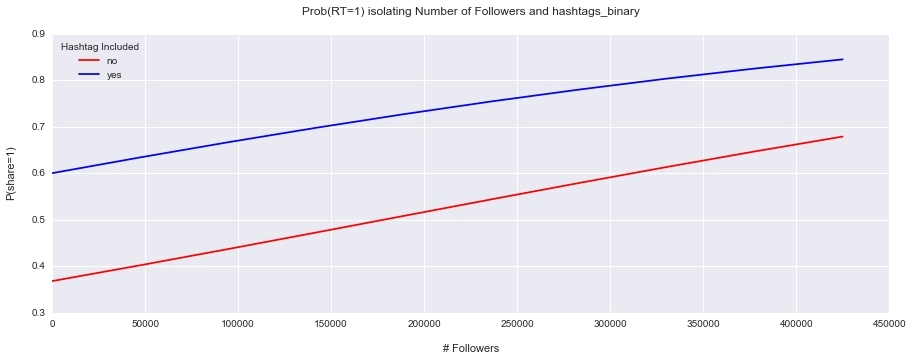

In [52]:
colors = 'rbgyrbgy'
for col in combos.hashtags_binary.unique():
    plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
    plt.plot(plt_data.index.get_level_values(0), plt_data['retweets_pred'], color=colors[int(col)])

plt.xlabel('# Followers', labelpad=15)
plt.ylabel("P(share=1)", labelpad=15)
plt.legend(['no', 'yes'], loc='upper left', title='Hashtag Included')
plt.title("Prob(RT=1) isolating " + "Number of Followers" + " and hashtags_binary", y=1.05)
savefig('predicted probabilities example (red-blue).png', bbox_inches='tight', dpi=300, format='png')
plt.show()

<br>Can you see how simplistic yet powerful such a plot is? Here we can clearly see the effects of our two variables. First, for `from_user_followers_count`, we can see a clear positive relationship between the number of followers and the probability of a tweet being retweeted. We can also see a clear difference in the predicted probabilities for a tweet with and without a hashtag across the entire observed range of number of followers. 

Without including a hashtag, a company needs to have around 180,000 followers before one of its tweets has a 50/50 chance of being retweeted; in contrast, any tweet with a hashtag stands at least a 60% chance of being retweeted, and this steadily increases to 84% at the maximum observed number of followers.

#### Plotting Method #2 - Formula

If we want to run these plots on multiple variables we can put the above steps together into one function. Thanks to `yhat` for the function: http://blog.yhathq.com/posts/logistic-regression-and-python.html

In [53]:
def isolate_and_plot(variable):
    # isolate gre and class rank
    
    #NOTE v. 0.16 OF PANDAS REQUIRES 'index=' rather than 'rows=' 
    #grouped = pd.pivot_table(combos, values=['retweets_pred'], rows=[variable, 'hashtags_binary'], aggfunc=np.mean)
    grouped = pd.pivot_table(combos, values=['retweets_pred'], index=[variable, 'hashtags_binary'], aggfunc=np.mean)

    colors = 'rbgyrbgy'
    for col in combos.hashtags_binary.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        plt.plot(plt_data.index.get_level_values(0), plt_data['retweets_pred'],
                color=colors[int(col)])
 
    plt.xlabel(variable, labelpad=15)
    plt.ylabel("P(share=1)", labelpad=15)
    plt.legend(['no', 'yes'], loc='upper left', title='Hashtag Included')
    plt.title("Prob(share=1) isolating " + variable + " and hashtags_binary", y=1.05)
    plt.show()

<br>We then invoke the function as follows to produce the plot for our chosen variable.

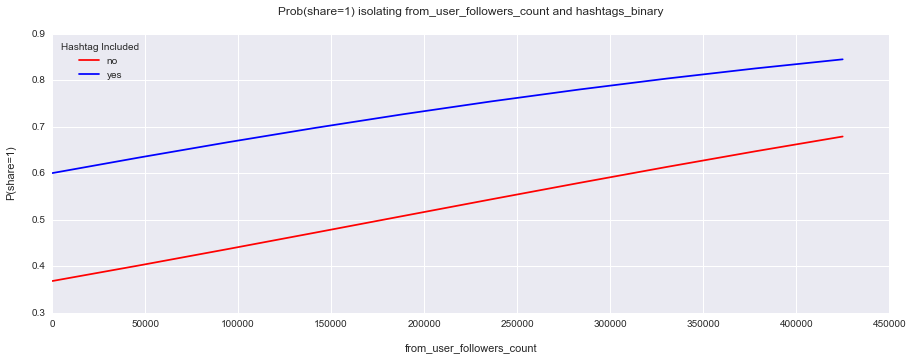

In [54]:
isolate_and_plot('from_user_followers_count')

#### Plotting Method #3: Create Separate Dataframes for each Condition and Plot Individually

This method might be easier for some people to follow. Notice that in grouped we have two indices; our command `grouped.index.get_level_values(1)==1` is asking for all those values where our second index, `hashtags_binary` has values of 1. If we want to get the first index we would write `grouped.index.get_level_values(0)==`.

In [55]:
plt_data1 = grouped.ix[grouped.index.get_level_values(1)==1]
plt_data0 = grouped.ix[grouped.index.get_level_values(1)==0]

In [57]:
plt_data0

,,retweets_pred
from_user_followers_count,hashtags_binary,
58.00,0.00,0.37
47261.78,0.00,0.40
94465.56,0.00,0.44
141669.33,0.00,0.47
188873.11,0.00,0.51
236076.89,0.00,0.54
283280.67,0.00,0.58
330484.44,0.00,0.61
377688.22,0.00,0.65


In [58]:
plt_data1

,,retweets_pred
from_user_followers_count,hashtags_binary,
58.00,1.00,0.60
47261.78,1.00,0.63
94465.56,1.00,0.67
141669.33,1.00,0.70
188873.11,1.00,0.73
236076.89,1.00,0.75
283280.67,1.00,0.78
330484.44,1.00,0.80
377688.22,1.00,0.83


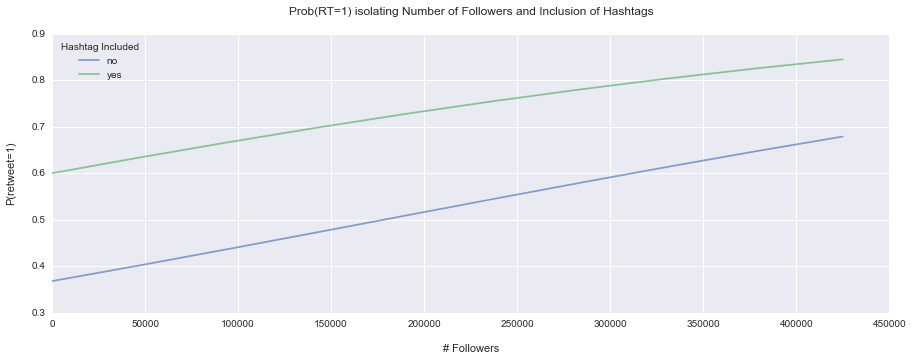

In [60]:
plt.plot(plt_data0.index.get_level_values(0), plt_data0['retweets_pred'], alpha=0.65)
plt.plot(plt_data1.index.get_level_values(0), plt_data1['retweets_pred'], alpha=0.65)
plt.xlabel('# Followers', labelpad=15)
plt.ylabel("P(retweet=1)", labelpad=15)
plt.legend(['no', 'yes'], loc='upper left', title='Hashtag Included')
plt.title("Prob(RT=1) isolating " + "Number of Followers" + " and Inclusion of Hashtags",  y=1.05)
yticks(fontsize = 10)
xticks(fontsize = 10)
savefig('predicted probabilities example (seaborn).png', bbox_inches='tight', dpi=300, format='png')

<br>Let's repeat with `mpl` style.

(array([      0.,   50000.,  100000.,  150000.,  200000.,  250000.,
         300000.,  350000.,  400000.,  450000.]),
 <a list of 10 Text xticklabel objects>)

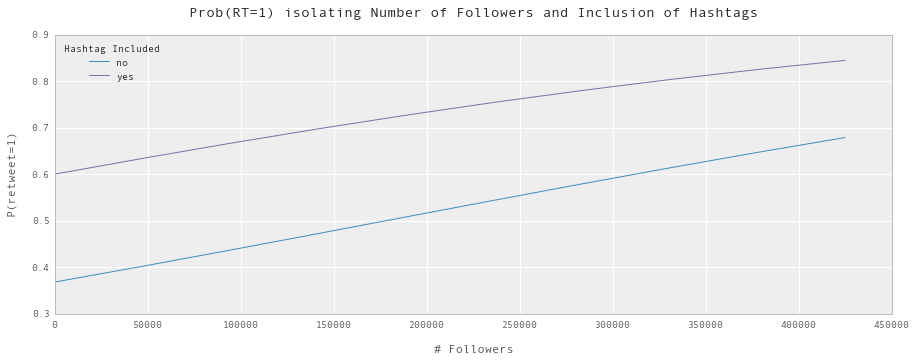

In [234]:
pd.set_option('display.mpl_style', 'default') # MPL style
plt.rcParams['figure.figsize'] = (15, 5)

plt.plot(plt_data0.index.get_level_values(0), plt_data0['retweets_pred'], alpha=0.95)
plt.plot(plt_data1.index.get_level_values(0), plt_data1['retweets_pred'], alpha=0.95)
plt.xlabel('# Followers', labelpad=15)
plt.ylabel("P(retweet=1)", labelpad=15)
plt.legend(['no', 'yes'], loc='upper left', title='Hashtag Included')
plt.title("Prob(RT=1) isolating " + "Number of Followers" + " and Inclusion of Hashtags",  y=1.05)
yticks(fontsize = 10)
xticks(fontsize = 10)
savefig('predicted probabilities example (mpl).png', bbox_inches='tight', dpi=300, format='png')

<br>Now with `ggplot` style.

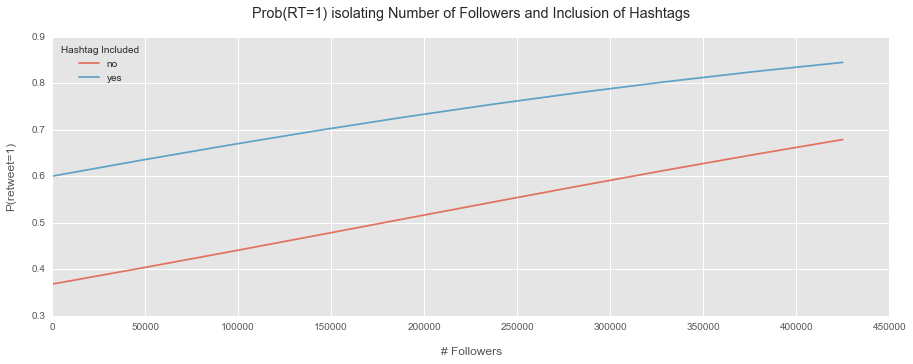

In [61]:
mpl.style.use('ggplot')

plt.plot(plt_data0.index.get_level_values(0), plt_data0['retweets_pred'], alpha=0.75)
plt.plot(plt_data1.index.get_level_values(0), plt_data1['retweets_pred'], alpha=0.75)
plt.xlabel('# Followers', labelpad=15)
plt.ylabel("P(retweet=1)", labelpad=15)
plt.legend(['no', 'yes'], loc='upper left', title='Hashtag Included')
plt.title("Prob(RT=1) isolating " + "Number of Followers" + " and Inclusion of Hashtags",  y=1.05)
yticks(fontsize = 10)
xticks(fontsize = 10)
savefig('predicted probabilities example (ggplot).png', bbox_inches='tight', dpi=300, format='png')

<br>And finally with `538` style.

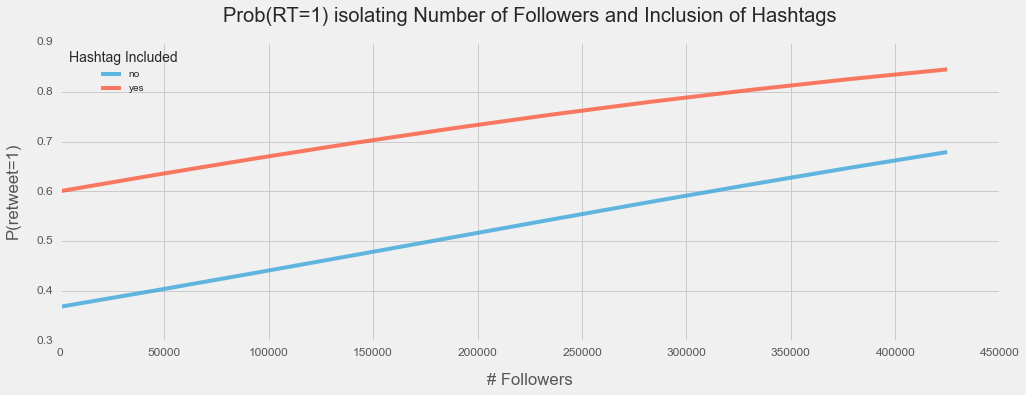

In [62]:
mpl.style.use('fivethirtyeight')

plt.plot(plt_data0.index.get_level_values(0), plt_data0['retweets_pred'], alpha=0.75)
plt.plot(plt_data1.index.get_level_values(0), plt_data1['retweets_pred'], alpha=0.75)
plt.xlabel('# Followers', labelpad=15)
plt.ylabel("P(retweet=1)", labelpad=15)
plt.legend(['no', 'yes'], loc='upper left', title='Hashtag Included')
plt.title("Prob(RT=1) isolating " + "Number of Followers" + " and Inclusion of Hashtags",  y=1.05)
yticks(fontsize = 12)
xticks(fontsize = 12)
savefig('predicted probabilities example (538).png', bbox_inches='tight', dpi=300, format='png')

<br>

For more Notebooks as well as additional Python and Big Data tutorials, please visit http://social-metrics.org or follow me on Twitter <a href='https://twitter.com/gregorysaxton'>@gregorysaxton</a>